# Reikalingi paketai

In [2]:
!pip install git+https://github.com/facebookresearch/esm.git@main biopython umap-learn hdbscan numpy torch


  Cloning https://github.com/facebookresearch/esm.git (to revision main) to /tmp/pip-req-build-mi3sxtna
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-mi3sxtna
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/21

# Pasirenkame GPU įrenginį

In [7]:
import os
from Bio import SeqIO
import torch
import esm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


# Užtikriname tik galimas amino rūgščių anotacijas

In [8]:
fasta_path = '/content/Smagellanicum_521_v1.1.protein_primaryTranscriptOnly.fa'

raw_records = list(SeqIO.parse(fasta_path, "fasta"))

MAX_LEN = 1022
cleaned_data = []
for rec in raw_records:
    seq = str(rec.seq)
    if len(seq) > MAX_LEN:
        continue
    seq = "".join([aa if aa in "ACDEFGHIKLMNPQRSTVWY" else "X" for aa in seq])
    cleaned_data.append((rec.id, seq))

print(f"Kept {len(cleaned_data)} / {len(raw_records)} sequences under {MAX_LEN} aa")

Kept 23478 / 25227 sequences under 1022 aa


# Persisiunčiame ESM-1b modelį ir užkrauname

In [ ]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
model = model.to(device)
model.eval()
batch_converter = alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


# Prognozuojame baltymų funkcijas su T4 GPU

In [ ]:
out_labels = []
out_embs   = []

BATCH_SIZE = 32
for i in range(0, len(cleaned_data), BATCH_SIZE):
    batch = cleaned_data[i:i+BATCH_SIZE]
    labels, seqs, tokens = batch_converter(batch)
    tokens = tokens.to(device)
    with torch.no_grad():
        results = model(tokens, repr_layers=[33], return_contacts=False)
    reps = results["representations"][33]
    for j, (lbl, seq) in enumerate(batch):
        emb = reps[j, 1:len(seq)+1].mean(0).cpu().numpy()
        out_labels.append(lbl)
        out_embs.append(emb)
    if (i//BATCH_SIZE) % 10 == 0:
        print(f"Processed {i+BATCH_SIZE} / {len(cleaned_data)} sequences")

embs_arr = np.stack(out_embs)
labels_arr = np.array(out_labels, dtype=object)
save_dir = '/content/esm_embeddings'
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, 'labels.npy'), labels_arr)
np.save(os.path.join(save_dir, 'embeddings.npy'), embs_arr)
print("Saved embeddings to", save_dir)

Processed 32 / 23478 sequences
Processed 352 / 23478 sequences
Processed 672 / 23478 sequences
Processed 992 / 23478 sequences
Processed 1312 / 23478 sequences
Processed 1632 / 23478 sequences
Processed 1952 / 23478 sequences
Processed 2272 / 23478 sequences
Processed 2592 / 23478 sequences
Processed 2912 / 23478 sequences
Processed 3232 / 23478 sequences
Processed 3552 / 23478 sequences
Processed 3872 / 23478 sequences
Processed 4192 / 23478 sequences
Processed 4512 / 23478 sequences
Processed 4832 / 23478 sequences
Processed 5152 / 23478 sequences
Processed 5472 / 23478 sequences
Processed 5792 / 23478 sequences
Processed 6112 / 23478 sequences
Processed 6432 / 23478 sequences
Processed 6752 / 23478 sequences
Processed 7072 / 23478 sequences
Processed 7392 / 23478 sequences
Processed 7712 / 23478 sequences
Processed 8032 / 23478 sequences
Processed 8352 / 23478 sequences
Processed 8672 / 23478 sequences
Processed 8992 / 23478 sequences
Processed 9312 / 23478 sequences
Processed 9632 

# Atliekame PCA sumažindami dimensijų kiekį iki 50 ir UMAP į 2 ašis.

In [4]:
import umap
from sklearn.decomposition import PCA

embeddings = np.load("/content/embeddings.npy", allow_pickle=True)

pca = PCA(n_components=50, random_state=7)
emb_pca = pca.fit_transform(embeddings)

reducer = umap.UMAP(n_components=2, random_state=7, min_dist=0.1)
emb_umap = reducer.fit_transform(emb_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
print(emb_umap.shape)

(23478, 2)


# Klasterizuojame

In [10]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10)
labels_uv = clusterer.fit_predict(emb_umap)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Atvaizduojame klasterius plokštumoje

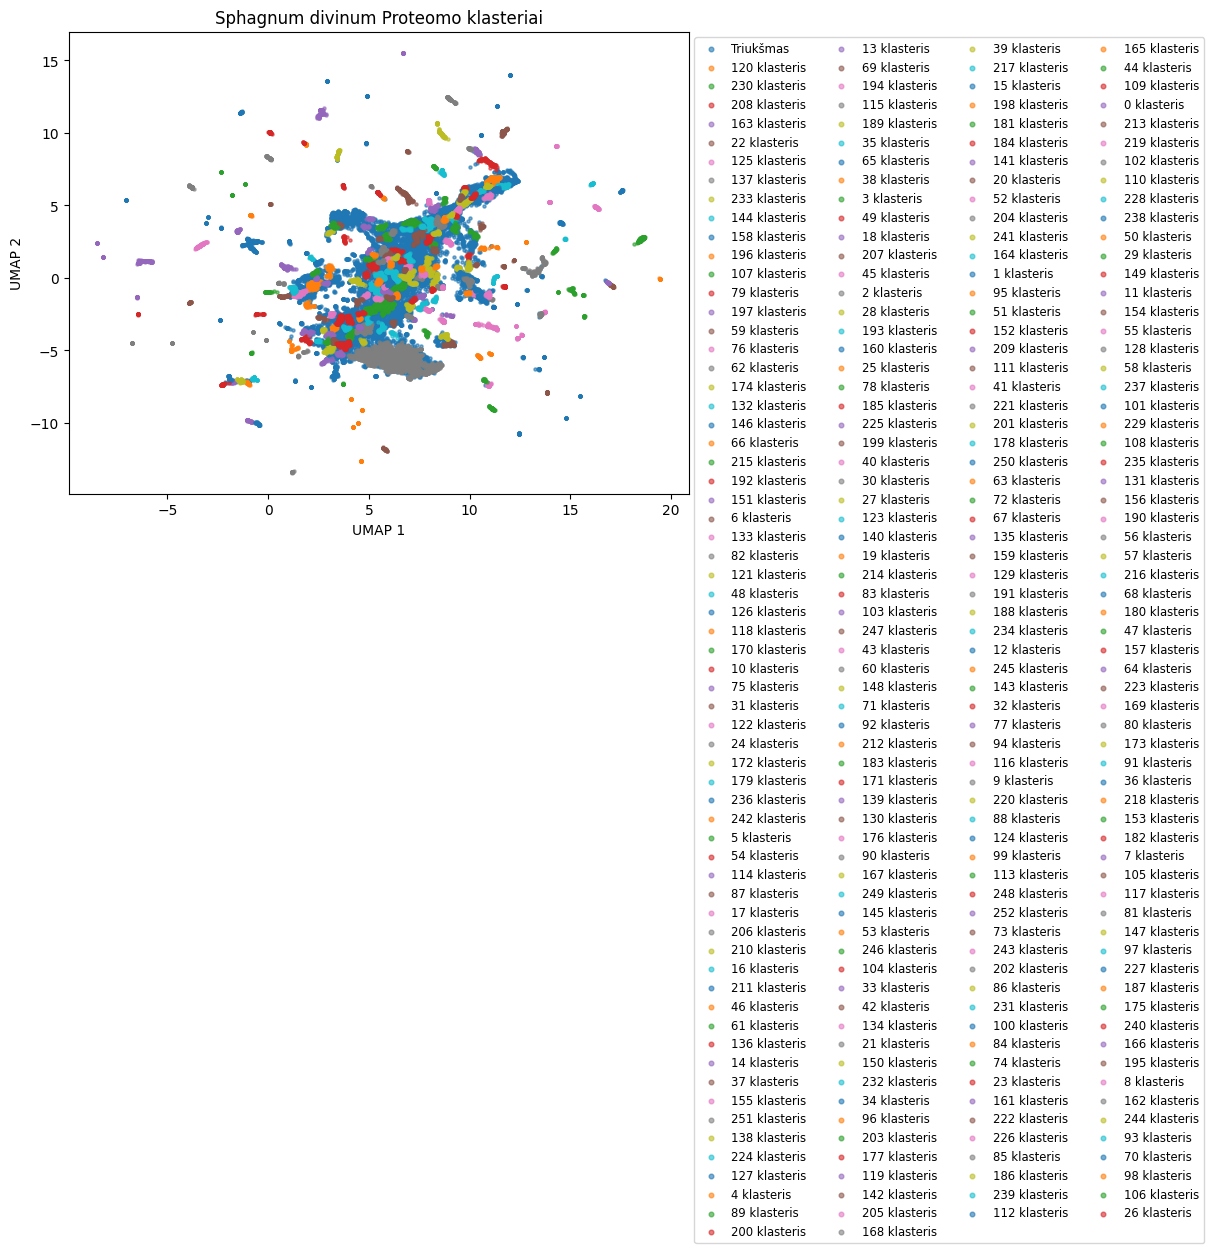

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

labels = np.load("/content/labels.npy", allow_pickle=True)
df = pd.DataFrame({
    "umap1": emb_umap[:, 0],
    "umap2": emb_umap[:, 1],
    "cluster": labels_uv,
    "protein": labels
})
df.to_csv("proteome_umap.csv", index=False)

plt.figure(figsize=(8,6))
for c in df["cluster"].unique():
    mask = df["cluster"] == c
    plt.scatter(df.loc[mask, "umap1"], df.loc[mask, "umap2"],
                s=5, label=f"{c} klasteris" if c!=-1 else "Triukšmas", alpha=0.6)

plt.legend(markerscale=1.5, fontsize="small", ncol=4, bbox_to_anchor=(1,1))
plt.title("Sphagnum divinum Proteomo klasteriai")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.savefig("cluster_map.png", dpi=300, bbox_inches="tight")
plt.show()

# Viso klasterių

In [ ]:
import pandas as pd
df = pd.read_csv("/content/proteome_umap.csv")
print(df['cluster'].nunique(dropna=True))

254


# Suliejame UMAP informaciją su anotacijomis

In [ ]:
import pandas as pd

umap_df = pd.read_csv("/content/proteome_umap.csv")
anno_df = pd.read_csv("/content/Smagellanicum_521_v1.1.annotation_info.txt", sep="\t")

anno_df.columns = [c.lstrip("#") for c in anno_df.columns]
anno_df = anno_df.rename(columns={"peptideName": "protein"})
annotated = umap_df.merge(
    anno_df,
    on="protein",
    how="left",
    indicator=True
)
annotated.to_csv("proteome_umap_with_AF2_annotations.csv", index=False)
annotated.head(10)


,umap1,umap2,cluster,protein,pacId,locusName,transcriptName,Pfam,Panther,KOG,ec,KO,GO,Best-hit-arabi-name,arabi-symbol,arabi-defline,_merge
0,4.567510,-3.164711,-1,Sphmag15G097500.1.p,41902063,Sphmag15G097500,Sphmag15G097500.1,PF01494,"PTHR13789,PTHR13789:SF234",KOG2614,NaN,NaN,GO:0071949,AT5G67030.2,"ABA1,ATABA1,ATZEP,IBS3,LOS6,NPQ2,ZEP",zeaxanthin epoxidase (ZEP) (ABA1),both
1,2.033166,-1.272340,-1,Sphmag15G070700.1.p,41902065,Sphmag15G070700,Sphmag15G070700.1,"PF03105,PF07690","PTHR23510,PTHR23510:SF4","KOG1161,KOG2325",NaN,NaN,"GO:0055085,GO:0016021",AT4G22990.2,NaN,Major Facilitator Superfamily with SPX (SYG1/P...,both
2,2.067077,-0.392925,120,Sphmag15G047900.1.p,41902066,Sphmag15G047900,Sphmag15G047900.1,PF03798,"PTHR12560,PTHR12560:SF13",KOG1607,NaN,K04710,"GO:0016021,GO:0005783",AT3G25540.1,LAG1,"TRAM, LAG1 and CLN8 (TLC) lipid-sensing domain...",both
3,4.772927,-1.652578,-1,Sphmag15G089200.1.p,41902072,Sphmag15G089200,Sphmag15G089200.1,NaN,"PTHR31096,PTHR31096:SF4",NaN,2.7.7.59,NaN,NaN,AT2G39570.1,NaN,ACT domain-containing protein,both
4,6.909477,3.394284,-1,Sphmag15G086800.1.p,41902073,Sphmag15G086800,Sphmag15G086800.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
5,5.389421,-2.564475,-1,Sphmag15G040500.1.p,41902074,Sphmag15G040500,Sphmag15G040500.1,"PF13410,PF01814,PF13417","PTHR35739,PTHR35739:SF1",KOG0406,2.5.1.18,NaN,GO:0005515,AT3G54290.1,NaN,NaN,both
6,6.569193,-0.279957,230,Sphmag15G092200.1.p,41902075,Sphmag15G092200,Sphmag15G092200.1,PF16575,"PTHR12755,PTHR12755:SF3",NaN,2.7.1.78,K06947,NaN,AT5G11010.2,NaN,Pre-mRNA cleavage complex II protein family,both
7,9.794045,6.199972,208,Sphmag15G045100.1.p,41902078,Sphmag15G045100,Sphmag15G045100.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
8,6.474842,3.604521,-1,Sphmag15G102000.1.p,41902079,Sphmag15G102000,Sphmag15G102000.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
9,4.967155,3.595650,163,Sphmag15G030800.1.p,41902080,Sphmag15G030800,Sphmag15G030800.1,PF05678,"PTHR33402,PTHR33402:SF3",NaN,NaN,NaN,NaN,AT1G28280.2,NaN,VQ motif-containing protein,both


# Patikriname klasterių grynumą

In [ ]:
import pandas as pd
from collections import Counter

df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
purity_records = []

for cluster_id, sub in df.groupby("cluster"):
    labels = sub["Pfam"].dropna().tolist()
    if not labels:
        continue
    top_label, top_count = Counter(labels).most_common(1)[0]
    purity = top_count / len(sub)
    purity_records.append({
        "cluster": cluster_id,
        "cluster_size": len(sub),
        "top_Pfam": top_label,
        "top_count": top_count,
        "purity": purity
    })

purity_df = pd.DataFrame(purity_records).sort_values("purity", ascending=False)
purity_df.to_csv("cluster_purity.csv", index=False)

In [ ]:
high_purity = purity_df[purity_df["purity"] >= 0.5]
print(high_purity)
low_purity = purity_df[purity_df["purity"] < 0.5]
print(low_purity)

     cluster  cluster_size         top_Pfam  top_count  purity
1          0            26  PF03953,PF00091         26     1.0
3          2            37  PF09118,PF07250         37     1.0
9         10            23          PF00504         23     1.0
5          4            21          PF07883         21     1.0
25        26            23          PF00190         23     1.0
..       ...           ...              ...        ...     ...
62        64            54  PF07714,PF12819         27     0.5
83        85            24          PF00012         12     0.5
69        71            24          PF16297         12     0.5
171      174            26          PF00221         13     0.5
136      139            28          PF00847         14     0.5

[68 rows x 5 columns]
     cluster  cluster_size         top_Pfam  top_count    purity
94        96            47  PF00005,PF01061         23  0.489362
165      168            41          PF07714         20  0.487805
159      162            35

In [ ]:
low_purity.to_csv("low_purity_clusters.csv", index=False)
high_purity.to_csv("high_purity_clusters.csv", index=False)

# Atliekame Fisherio testą su GO identifikatoriais klasteriuose

In [ ]:
import scipy.stats as stats

df["GO1"] = df["GO"].str.split(";", expand=True)[0].fillna("None")

results = []
clusters = df["cluster"].unique()
terms    = df["GO1"].unique()

for cluster_id in clusters:
    in_cluster = df["cluster"] == cluster_id
    for term in terms:
        in_term = df["GO1"] == term
        a = ((in_cluster) & (in_term)).sum()
        b = ((in_cluster) & (~in_term)).sum()
        c = ((~in_cluster) & (in_term)).sum()
        d = ((~in_cluster) & (~in_term)).sum()
        if a + b == 0 or a + c == 0:
            continue
        _, pval = stats.fisher_exact([[a,b],[c,d]], alternative="greater")

        if pval < 0.01:
            results.append({
                "cluster": cluster_id,
                "term": term,
                "count_in_cluster": a,
                "cluster_size": a+b,
                "p_value": pval
            })

enrich_df = pd.DataFrame(results).sort_values("p_value")
print(enrich_df.head())
enrich_df.to_csv("cluster_enrichments.csv", index=False)

      cluster                                         term  count_in_cluster  \
626        18  GO:0055114,GO:0020037,GO:0016705,GO:0005506               157   
402        24  GO:0055114,GO:0020037,GO:0006979,GO:0004601                83   
708       140                        GO:0006355,GO:0003700                89   
687        30             GO:0006281,GO:0003678,GO:0000723                69   
1317       68                        GO:0046872,GO:0030001                52   

      cluster_size        p_value  
626            157  2.030610e-321  
402             83  6.333388e-226  
708            115  9.648273e-195  
687             79  4.455664e-167  
1317            64  1.599517e-129  


# Atvaizduojame klasterius pagal jų grynumą

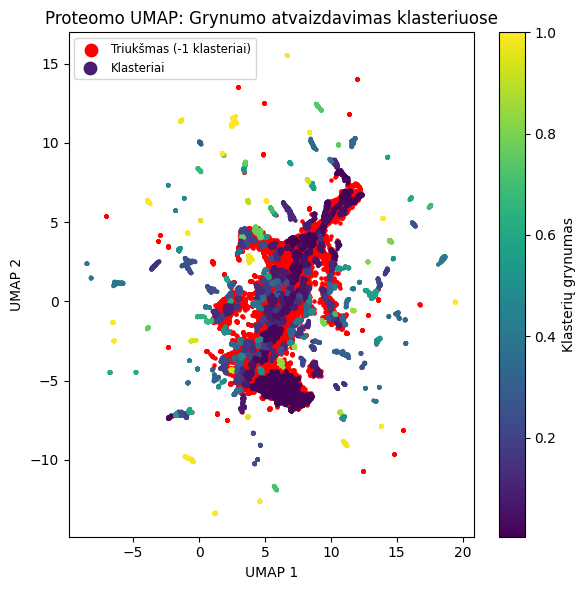

In [30]:
import matplotlib.pyplot as plt

df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
purity_df = pd.read_csv("cluster_purity.csv")

df = df.merge(purity_df[["cluster","purity"]], on="cluster", how="left")

mask_noise  = df["cluster"] == -1
mask_clusters = ~mask_noise

df_clusters = df[mask_clusters]
df_noise  = df[mask_noise]

plt.figure(figsize=(6,6))

plt.scatter(
    df_noise["umap1"],
    df_noise["umap2"],
    c="red",
    s=5,
    label="Triukšmas (-1 klasteriai)"
)
sc = plt.scatter(
    df_clusters["umap1"],
    df_clusters["umap2"],
    c=df_clusters["purity"],
    cmap="viridis",
    s=5,
    label="Klasteriai"
)
plt.colorbar(sc, label="Klasterių grynumas")

plt.legend(markerscale=4, fontsize="small", loc="best")
plt.title("Proteomo UMAP: Grynumo atvaizdavimas klasteriuose")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.savefig("cluster_map_with_purity.png", dpi=300, bbox_inches="tight")
plt.show()

# Sphmag13G047200

Nustatome baltymo klasterį. Bei visus baltymus esančius klasteryje.



In [ ]:
import pandas as pd

df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
target = "Sphmag13G047200.1.p"

mask_target = df["protein"] == target

if mask_target.sum() == 0:
    raise ValueError(f"{target} not found in the table.")

cluster_id = df.loc[mask_target, "cluster"].iloc[0]
print(f"{target} is in cluster {cluster_id}")
cluster_df = df[df["cluster"] == cluster_id]

print(f"\nAll proteins in cluster {cluster_id} (Overall: {cluster_df['protein'].nunique()} proteins):")
print(cluster_df[["protein", "arabi-defline"]].to_string(index=False))


Sphmag13G047200.1.p is in cluster 18

All proteins in cluster 18 (Overall: 157 proteins):
            protein                                           arabi-defline
Sphmag15G044900.1.p                     Cytochrome P450 superfamily protein
Sphmag15G004600.1.p                     Cytochrome P450 superfamily protein
Sphmag15G035500.1.p                     Cytochrome P450 superfamily protein
Sphmag02G081700.1.p                     Cytochrome P450 superfamily protein
Sphmag02G165800.1.p                     Cytochrome P450 superfamily protein
Sphmag02G208100.1.p                     Cytochrome P450 superfamily protein
Sphmag02G081600.1.p                     Cytochrome P450 superfamily protein
Sphmag02G097100.1.p  cytochrome P450, family 82, subfamily G, polypeptide 1
Sphmag05G100200.1.p                     Cytochrome P450 superfamily protein
Sphmag05G110500.1.p                     Cytochrome P450 superfamily protein
Sphmag05G000400.1.p  cytochrome P450, family 76, subfamily C, polypeptide 

Paryškiname klasterį UMAP'e

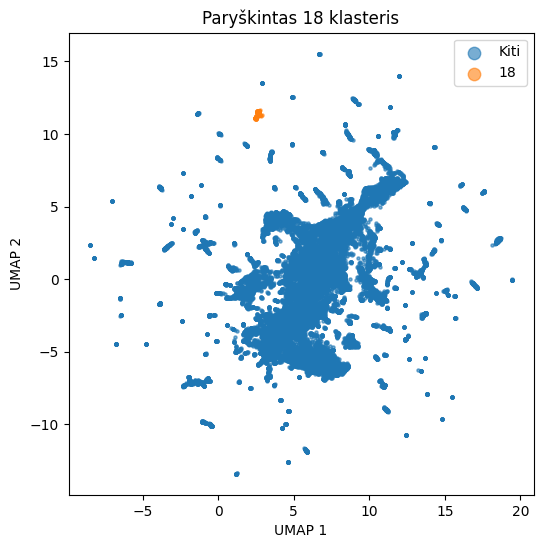

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_of_interest = 18
df = pd.read_csv("/content/proteome_umap_with_AF2_annotations.csv")
df["in_cluster"] = df["cluster"] == cluster_of_interest

plt.figure(figsize=(6,6))
for flag, grp in df.groupby("in_cluster"):
    lbl = cluster_of_interest if flag else "Kiti"
    plt.scatter(grp["umap1"], grp["umap2"], s=5, label=lbl, alpha=0.6)
plt.legend(markerscale=4)
plt.title(f"Paryškintas {cluster_of_interest} klasteris")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig(f"cluster_{cluster_of_interest}.png", dpi=300, bbox_inches="tight")
plt.show()

Surenkame GO identifikatorius

In [ ]:
fisher_df = pd.read_csv("cluster_enrichments.csv")

target_cluster = 18
cluster_info = fisher_df.loc[fisher_df['cluster'] == target_cluster]
print(cluster_info)

   cluster                                         term  count_in_cluster  \
0       18  GO:0055114,GO:0020037,GO:0016705,GO:0005506               157   

   cluster_size        p_value  
0           157  2.030610e-321  


Tikriname klasterio grynumą

In [ ]:
purity_df = pd.read_csv("cluster_purity.csv")

target_cluster = 18
cluster_info = purity_df.loc[purity_df['cluster'] == target_cluster]
print(cluster_info)

   cluster  cluster_size top_Pfam  top_count  purity
7       18           157  PF00067        157     1.0


# Sphmag01G194900 ir Sphmag02G160700

Nustatome baltymo klasterį. Bei visus baltymus esančius klasteryje.

In [ ]:
import pandas as pd

df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
target = "Sphmag02G160700.1.p"
# target = "Sphmag01G194900.1.p"
mask_target = df["protein"] == target

if mask_target.sum() == 0:
    raise ValueError(f"{target} not found in the table.")

cluster_id = df.loc[mask_target, "cluster"].iloc[0]
print(f"{target} is in cluster {cluster_id}")
cluster_df = df[df["cluster"] == cluster_id]

print(f"\nAll proteins in cluster {cluster_id} (Overall: {cluster_df['protein'].nunique()} proteins):")
print(cluster_df[["protein", "arabi-defline"]].to_string(index=False))

Sphmag02G160700.1.p is in cluster -1

All proteins in cluster -1 (Overall: 7479 proteins):
            protein                                                                                                                                                                                                                                                   arabi-defline
Sphmag15G097500.1.p                                                                                                                                                                                                                               zeaxanthin epoxidase (ZEP) (ABA1)
Sphmag15G070700.1.p                                                                                                                                                                              Major Facilitator Superfamily with SPX (SYG1/Pho81/XPR1) domain-containing protein
Sphmag15G089200.1.p                                                              

Ieškome Sphmag01G194900 kaimynų

In [ ]:
import pandas as pd

def get_neighbors(df, center_protein, umap1_dist, umap2_dist):
    if center_protein not in df['protein'].values:
        raise ValueError(f"Center protein '{center_protein}' not found in the dataset.")

    center_row = df[df['protein'] == center_protein].iloc[0]
    center_umap1 = center_row['umap1']
    center_umap2 = center_row['umap2']

    mask = (
        df['umap1'].between(center_umap1 - umap1_dist, center_umap1 + umap1_dist) &
        df['umap2'].between(center_umap2 - umap2_dist, center_umap2 + umap2_dist)
    )
    neighbors = df[mask].copy()
    return neighbors[neighbors['protein'] != center_protein]

csv_path = 'proteome_umap_with_AF2_annotations.csv'
center_protein = 'Sphmag01G194900.1.p'
umap1_dist = 0.1
umap2_dist = 0.1

df = pd.read_csv(csv_path)

neighbors_df = get_neighbors(df, center_protein, umap1_dist, umap2_dist)

print(f"Found {len(neighbors_df)} neighbors of '{center_protein}' within "
      f"+/-{umap1_dist} in UMAP1 and +/-{umap2_dist} in UMAP2.")

print(neighbors_df[['protein', 'umap1', 'umap2']])


Found 7 neighbors of 'Sphmag01G194900.1.p' within +/-0.1 in UMAP1 and +/-0.1 in UMAP2.
                   protein     umap1     umap2
2513   Sphmag02G160700.1.p  3.240320 -5.361597
6157   Sphmag09G052400.1.p  3.243428 -5.373094
14122  Sphmag12G012700.1.p  3.217584 -5.400518
15789  Sphmag01G027100.1.p  3.237576 -5.384900
16822  Sphmag01G054800.1.p  3.263450 -5.279047
17030  Sphmag01G123700.1.p  3.181390 -5.380647
23351  Sphmag20G015800.1.p  3.230697 -5.276911


Išsaugome informaciją apie kaimynus

In [ ]:
df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
proteins_of_interest = neighbors_df['protein'].tolist()
subset = df[df['protein'].isin(proteins_of_interest)]
print(subset)
subset.to_csv("Sphmag01G194900_neighbors.csv", index=False)

          umap1     umap2  cluster              protein     pacId  \
2513   3.240320 -5.361597       -1  Sphmag02G160700.1.p  41907036   
6157   3.243428 -5.373094       -1  Sphmag09G052400.1.p  41914528   
14122  3.217584 -5.400518       -1  Sphmag12G012700.1.p  41930551   
15789  3.237576 -5.384900       -1  Sphmag01G027100.1.p  41933917   
16822  3.263450 -5.279047       -1  Sphmag01G054800.1.p  41935907   
17030  3.181390 -5.380647       -1  Sphmag01G123700.1.p  41936364   
23351  3.230697 -5.276911       -1  Sphmag20G015800.1.p  41948669   

             locusName     transcriptName                     Pfam  \
2513   Sphmag02G160700  Sphmag02G160700.1                  PF01680   
6157   Sphmag09G052400  Sphmag09G052400.1                  PF01680   
14122  Sphmag12G012700  Sphmag12G012700.1                  PF01680   
15789  Sphmag01G027100  Sphmag01G027100.1                  PF05690   
16822  Sphmag01G054800  Sphmag01G054800.1                  PF01269   
17030  Sphmag01G123700  Sph

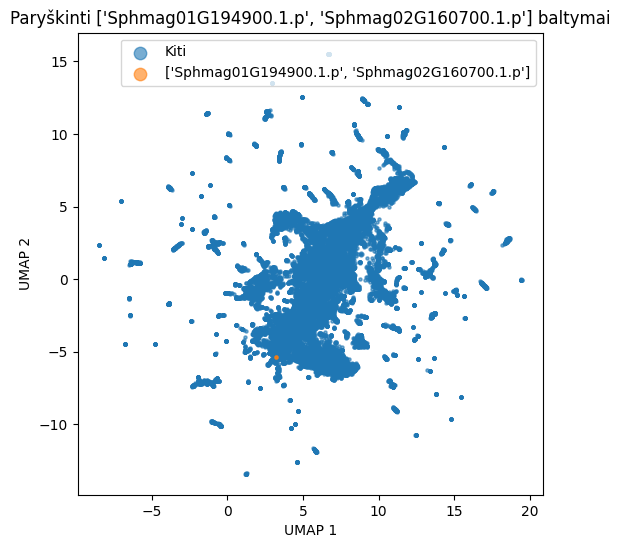

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

proteins_of_interest = ['Sphmag01G194900.1.p', 'Sphmag02G160700.1.p']
df = pd.read_csv("/content/proteome_umap_with_AF2_annotations.csv")
df["is_in"] = df['protein'].isin(proteins_of_interest)

plt.figure(figsize=(6,6))
for flag, grp in df.groupby("is_in"):
    lbl = proteins_of_interest if flag else "Kiti"
    plt.scatter(grp["umap1"], grp["umap2"], s=5, label=lbl, alpha=0.6)
plt.legend(markerscale=4)
plt.title(f"Paryškinti {proteins_of_interest} baltymai")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig(f"{proteins_of_interest[0]}_{proteins_of_interest[1]}.png", dpi=300, bbox_inches="tight")
plt.show()

# Sphmag08G106500

Nustatome baltymo klasterį. Bei visus baltymus esančius klasteryje.

In [ ]:
import pandas as pd

df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
target = "Sphmag08G106500.1.p"

mask_target = df["protein"] == target

if mask_target.sum() == 0:
    raise ValueError(f"{target} not found in the table.")

cluster_id = df.loc[mask_target, "cluster"].iloc[0]
print(f"{target} is in cluster {cluster_id}")
cluster_df = df[df["cluster"] == cluster_id]

print(f"\nAll proteins in cluster {cluster_id} (Overall: {cluster_df['protein'].nunique()} proteins):")
print(cluster_df[["protein", "arabi-defline"]].to_string(index=False))


Sphmag08G106500.1.p is in cluster 220

All proteins in cluster 220 (Overall: 26 proteins):
            protein                                                  arabi-defline
Sphmag15G049400.1.p                                                            NaN
Sphmag02G159800.1.p                                                            NaN
Sphmag05G086100.1.p                                                            NaN
Sphmag17G054200.1.p                                                            NaN
Sphmag09G031300.1.p                                                            NaN
Sphmag14G111400.1.p                                                            NaN
Sphmag14G094300.1.p                                                            NaN
Sphmag03G015300.1.p   Calcineurin-like metallo-phosphoesterase superfamily protein
Sphmag08G106500.1.p                                                            NaN
Sphmag08G006800.1.p                      ATP synthase epsilon chain, mitochondr

Surenkame GO identifikatorius

In [ ]:
fisher_df = pd.read_csv("cluster_enrichments.csv")

target_cluster = 220
cluster_info = fisher_df.loc[fisher_df['cluster'] == target_cluster]
print(cluster_info)

      cluster                                         term  count_in_cluster  \
919       220                                          NaN                21   
1127      220  GO:0046961,GO:0046933,GO:0015986,GO:0000275                 1   

      cluster_size   p_value  
919             26  0.001766  
1127            26  0.004423  


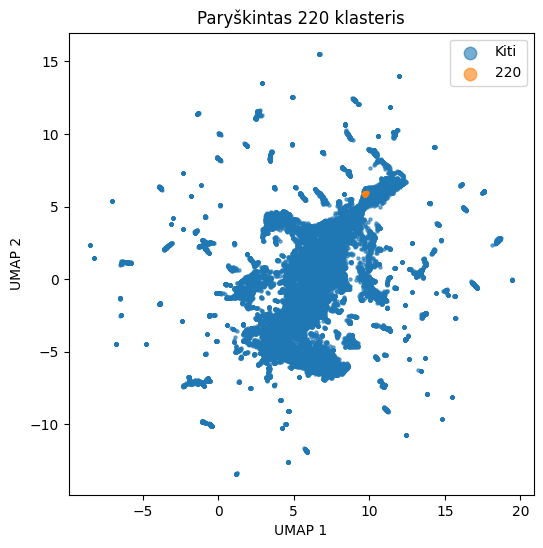

In [ ]:
cluster_of_interest = 220
df = pd.read_csv("/content/proteome_umap_with_AF2_annotations.csv")
df["in_cluster"] = df["cluster"] == cluster_of_interest

plt.figure(figsize=(6,6))
for flag, grp in df.groupby("in_cluster"):
    lbl = cluster_of_interest if flag else "Kiti"
    plt.scatter(grp["umap1"], grp["umap2"], s=5, label=lbl, alpha=0.6)
plt.legend(markerscale=4)
plt.title(f"Paryškintas {cluster_of_interest} klasteris")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig(f"cluster_{cluster_of_interest}.png", dpi=300, bbox_inches="tight")
plt.show()

# Sphmag01G192500

In [ ]:
import pandas as pd

df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
target = "Sphmag01G192500.1.p"

mask_target = df["protein"] == target

if mask_target.sum() == 0:
    raise ValueError(f"{target} not found in the table.")

cluster_id = df.loc[mask_target, "cluster"].iloc[0]
print(f"{target} is in cluster {cluster_id}")
cluster_df = df[df["cluster"] == cluster_id]

print(f"\nAll proteins in cluster {cluster_id} (Overall: {cluster_df['protein'].nunique()} proteins):")
print(cluster_df[["protein", "arabi-defline"]].to_string(index=False))

Sphmag01G192500.1.p is in cluster 205

All proteins in cluster 205 (Overall: 27 proteins):
            protein                                    arabi-defline
Sphmag15G019300.1.p              Protein of unknown function, DUF547
Sphmag15G051700.1.p              Protein of unknown function, DUF547
Sphmag15G035100.1.p              Protein of unknown function, DUF547
Sphmag15G055500.1.p             DHHC-type zinc finger family protein
Sphmag02G133100.1.p             DHHC-type zinc finger family protein
Sphmag02G138700.1.p                                SPX domain gene 4
Sphmag05G060100.1.p             DHHC-type zinc finger family protein
Sphmag05G044800.1.p                                     SKP1-like 21
Sphmag05G026400.1.p             Protein of unknown function (DUF668)
Sphmag17G011200.1.p      Uncharacterised conserved protein UCP009193
Sphmag08G124000.1.p        PLATZ transcription factor family protein
Sphmag08G134500.1.p          zinc knuckle (CCHC-type) family protein
Sphmag08G092

In [ ]:
fisher_df = pd.read_csv("cluster_enrichments.csv")

target_cluster = 205
cluster_info = fisher_df.loc[fisher_df['cluster'] == target_cluster]
print(cluster_info)
cluster_info.to_csv("205_cluster_info.csv")

     cluster                                               term  \
391      205                                         GO:0008270   
862      205  GO:0008270,GO:0003676,GO:0048478,GO:0007049,GO...   

     count_in_cluster  cluster_size       p_value  
391                 5            27  4.988065e-08  
862                 1            27  1.150013e-03  


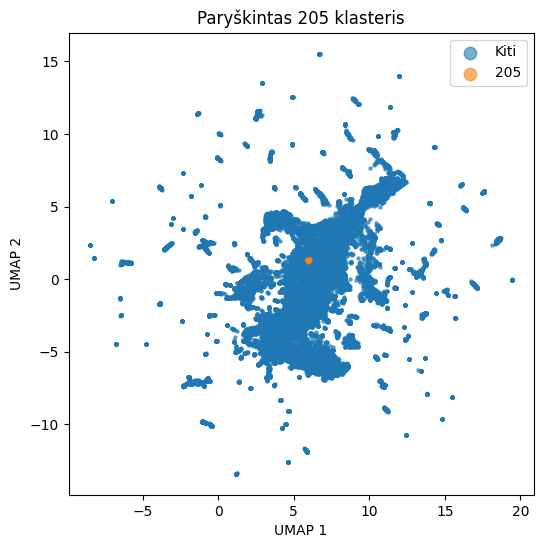

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_of_interest = 205
df = pd.read_csv("/content/proteome_umap_with_AF2_annotations.csv")
df["in_cluster"] = df["cluster"] == cluster_of_interest

plt.figure(figsize=(6,6))
for flag, grp in df.groupby("in_cluster"):
    lbl = cluster_of_interest if flag else "Kiti"
    plt.scatter(grp["umap1"], grp["umap2"], s=5, label=lbl, alpha=0.6)
plt.legend(markerscale=4)
plt.title(f"Paryškintas {cluster_of_interest} klasteris")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig(f"cluster_{cluster_of_interest}.png", dpi=300, bbox_inches="tight")
plt.show()

# Sphmag01G058000

In [ ]:
import pandas as pd

df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
target = "Sphmag01G058000.1.p"

mask_target = df["protein"] == target

if mask_target.sum() == 0:
    raise ValueError(f"{target} not found in the table.")

cluster_id = df.loc[mask_target, "cluster"].iloc[0]
print(f"{target} is in cluster {cluster_id}")
cluster_df = df[df["cluster"] == cluster_id]

print(f"\nAll proteins in cluster {cluster_id} (Overall: {cluster_df['protein'].nunique()} proteins):")
print(cluster_df[["protein", "arabi-defline"]].to_string(index=False))

Sphmag01G058000.1.p is in cluster 41

All proteins in cluster 41 (Overall: 131 proteins):
            protein                                                                         arabi-defline
Sphmag15G014800.1.p                                                                                   NaN
Sphmag15G064700.1.p                                                                                   NaN
Sphmag15G002000.1.p late embryogenesis abundant domain-containing protein / LEA domain-containing protein
Sphmag02G029000.1.p                                                                                   NaN
Sphmag02G141200.1.p                                                                                   NaN
Sphmag02G037100.1.p                                                                                   NaN
Sphmag02G198500.1.p late embryogenesis abundant domain-containing protein / LEA domain-containing protein
Sphmag02G111700.1.p                                           

In [ ]:
fisher_df = pd.read_csv("cluster_enrichments.csv")

target_cluster = 41
cluster_info = fisher_df.loc[fisher_df['cluster'] == target_cluster]
print(cluster_info)

      cluster                                         term  count_in_cluster  \
14         41                                   GO:0006950                41   
161        41  GO:0006334,GO:0005634,GO:0003677,GO:0000786                 9   
623        41                        GO:0009415,GO:0006950                 2   
1201       41                                   GO:0009790                 1   

      cluster_size       p_value  
14             131  5.761929e-83  
161            131  1.847683e-16  
623            131  3.089662e-05  
1201           131  5.579692e-03  


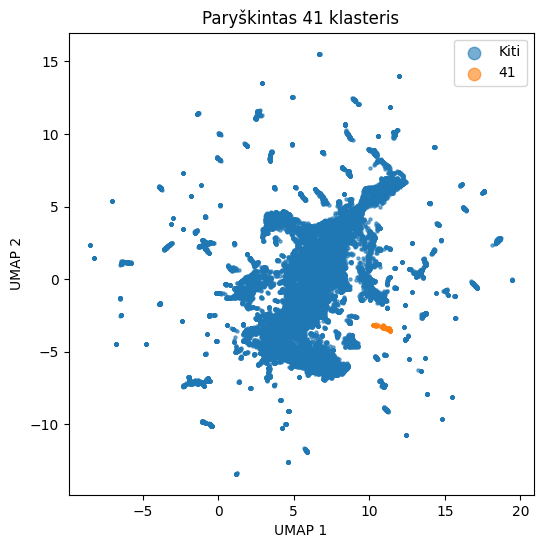

In [ ]:
cluster_of_interest = 41
df = pd.read_csv("/content/proteome_umap_with_AF2_annotations.csv")
df["in_cluster"] = df["cluster"] == cluster_of_interest

plt.figure(figsize=(6,6))
for flag, grp in df.groupby("in_cluster"):
    lbl = cluster_of_interest if flag else "Kiti"
    plt.scatter(grp["umap1"], grp["umap2"], s=5, label=lbl, alpha=0.6)
plt.legend(markerscale=4)
plt.title(f"Paryškintas {cluster_of_interest} klasteris")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig(f"cluster_{cluster_of_interest}.png", dpi=300, bbox_inches="tight")
plt.show()

# Kiti klasteriai

In [ ]:
import pandas as pd

df = pd.read_csv("cluster_purity.csv")
mask_target = df["purity"] == 1.0

cluster_ids = df.loc[mask_target, "cluster"]
anno_df = pd.read_csv("proteome_umap_with_AF2_annotations.csv")
overall_df = anno_df[anno_df["cluster"].isin(cluster_ids)].copy()
for cluster_id in cluster_ids:
    subset = anno_df[anno_df['cluster'] == cluster_id]
    print(f"\nAll proteins in cluster {cluster_id} (Overall: {subset['protein'].nunique()} proteins):")
    print(subset[["protein", "arabi-defline"]].to_string(index=False))



All proteins in cluster 0 (Overall: 26 proteins):
            protein               arabi-defline
Sphmag15G056100.1.p             tubulin alpha-5
Sphmag02G074000.1.p              tubulin beta 8
Sphmag02G042700.1.p       tubulin alpha-4 chain
Sphmag02G074100.1.p              tubulin beta 8
Sphmag05G117800.1.p       tubulin alpha-4 chain
Sphmag05G148400.1.p       tubulin alpha-2 chain
Sphmag05G084200.1.p              tubulin beta 8
Sphmag05G084100.1.p              tubulin beta 8
Sphmag05G084000.1.p              tubulin beta 8
Sphmag17G071300.1.p              tubulin beta 8
Sphmag13G026300.1.p             tubulin alpha-5
Sphmag08G004900.1.p       tubulin alpha-2 chain
Sphmag08G073300.1.p              tubulin beta 8
Sphmag08G073500.1.p              tubulin beta 8
Sphmag08G073400.1.p              tubulin beta 8
Sphmag12G033600.1.p        tubulin beta chain 3
Sphmag01G110700.1.p              tubulin beta 8
Sphmag07G057700.1.p Tubulin/FtsZ family protein
Sphmag07G123900.1.p        tubulin be

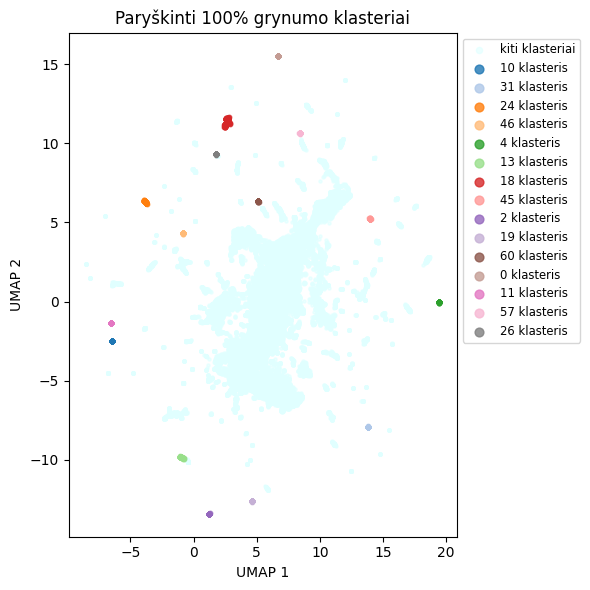

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/proteome_umap_with_AF2_annotations.csv")
target_clusters = overall_df['cluster'].unique()
cmap = plt.get_cmap("tab20")
colors = {cl: cmap(i) for i, cl in enumerate(target_clusters)}

plt.figure(figsize=(6,6))
others = df[~df["cluster"].isin(target_clusters)]
plt.scatter(
    others["umap1"], others["umap2"],
    c="lightcyan", s=5, label="kiti klasteriai", alpha=0.6
)
for cl in target_clusters:
    sub = df[df["cluster"] == cl]
    plt.scatter(
        sub["umap1"], sub["umap2"],
        c=[colors[cl]],
        s=10,
        label=f"{cl} klasteris",
        alpha=0.8
    )

plt.legend(markerscale=2, fontsize="small", ncol=1, loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Paryškinti 100% grynumo klasteriai")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.savefig(f"highlight_pure_clusters.png", dpi=300, bbox_inches="tight")
plt.show()